## Variational Deep Embedding (VaDE)

###  <div align=center> Moon Il-chul(icmoon@kaist.ac.kr); Jo Su-hyeon(suhyeonjo@kaist.ac.kr) </div> 

본 코드는 MNIST 데이터셋을 이용한 Variational Deep Embedding(VaDE)의 구현 예시입니다.   
본 코드를 통해서 VaDE의 구조와 생성, 학습 과정을 익힐 수 있습니다.   

## The Generative Process of VaDE
VaDE는 Variational Autoencoder(VAE)와 Gaussian Mixture Model(GMM)을 결합한 Unsupervised generative clustering framework입니다. VaDE의 data generative process는 다음과 같습니다.   
1. Choose a cluster $c$ ~ $Cat(\pi)$

2. Choose a latent vector $h$ ~ $N(\mu _{c}, \sigma_{c}^{2}I)$
3. Choose a sample $e$:   
    (1) $e$ is binary : $e$ ~ $Ber(\mu_{e})$   
    (2) $e$ is real-valued : $e$ ~ $N(\mu_{e},\sigma_{e}^{2}I)$      
        
이때 latent variable $h$는 observation을 통해 encode된 것으로, 이는 VAE에서의 encode과정입니다.   
$K$개의 cluster가 있을때 $\pi_{k}$는 cluster $k$의 prior probability 입니다.   
$Cat(\pi)$는 categorical distribution입니다.   
$\mu _{c}$, $\sigma_{c}^{2}$는 cluster $c$에 대응하는 Gaussian distribution의 mean과 variance입니다.   
$Ber(\mu_{x})$ 와 $N(\mu_{e},\sigma_{e}^{2}I)$는 각각 multivariate Bernoulli distribution과 Gaussian distribution을 나타냅니다.
   
Generatove process에 따르면, $p(e,h,c)$의 joint probability는 다음과 같이 factorize 될 수 있습니다.   
   
$p(e,h,c) = p(e|h)p(h|c)p(c)$
+ $p(c) = Cat(\pi)$   
+ $p(h|c) = N(h|\mu _{c}, \sigma_{c}^{2}I)$   
+ $p(e|h) = Ber(\mu_{e|\mu_{e}})$ or $N(e|\mu_{e},\sigma_{e}^{2}I)$   

## Variational Lower Bound
VaDE instance는 given data points ($e$)의 likelihood를 maximize하기 위해 조정됩니다. 위의 generative process에 따라, Jenson 부등식을 활용하여 VaDE의 log-likelihood를 다음과 같이 표현할 수 있습니다.   
$$logp(e) = log\int_{h}\sum_{c}p(e,h,c)dh \geq E_{q_{\phi}(h,c|e)}[log\frac{p(e,h,c)}{q(h,c|e)}]=\mathcal{L}_{ELBO}$$
   
   
   
ELBO를 다음과 같이 작성할 수 있습니다.
$$\mathcal{L}_{ELBO} \ = \  E_{q_{\phi}(h,c|e)}[log\frac{p(e,h,c)}{q(h,c|e)}]\ = \ E_{q_{\phi}(h,c|e)}[logp(e,h,c)-logq(h,c|x)]$$
$$= E_{q_{\phi}(h,c|e)}[logp(e|h)+logp(h|c)+logp(c)-logq(h|e)-logq(c|e)]$$   
   
이때 $q(h,c|e)$는 variational posterior로, mean field assumption을 통해 다음과 같이 factorize됩니다.
$$q(h,c|e) \approx q(h|e)q(c|e)$$
각각의 posterior는 다음과 같습니다.
+ $q_{\phi}(h|e)=N(h;\widetilde{\mu},\widetilde{\sigma}^{2}I)\ , \ \widetilde{\mu}=NN_{\widetilde{\mu}}(e)\ , \ log\widetilde{\sigma}=NN_{\widetilde{\sigma}}(e)$   
+ $q(h|e)$는 GMM의 assignment probbility에 의해 추정됩니다.   
   
   
   
Probability Distribution Function을 적용하여 ELBO를 유도한 결과는 다음과 같습니다.
$$\mathcal{L}_{ELBO}\ = \ \frac{1}{L}\sum_{l=1}^{L}\sum_{i=1}^{D}e_{i}log\mu_{e}^{(l)}|_{i}+(1-e_{i})log(1-\mu_{e}^{l}|_{i})-\sum_{c=1}^{K}q(c|e)[\frac{J}{2}log(2\pi)+\frac{1}{2}\left\{  \sum_{j=1}^{J}log\sigma_{c}^{2}|_{j}+\sum_{j=1}^{J}log\sigma_{c}^{2}|_{j}+\sum_{j=1}^{J}\frac{\widetilde{\sigma}_{j}^{2}}{\sigma_{c}^{2}|_{j}}+\sum_{j=1}^{J}\frac{(\widetilde{\mu}_{j}-\mu_{c}|_{j})^{2}}{2\sigma_{c}^{2}|_{j}}\right\}]\\
+\sum_{c=1}^{K}q(c|e)log\pi_{c}-\frac{J}{2}log(2\pi)+\frac{1}{2}\sum_{j=1}^{J}(log(\widetilde{\sigma}_{j}^{2})+1)-\sum_{c=1}^{K}q(c|e)logq(c|e) $$
   
$q(c|e)$ (gamma fuction)을 찾기 위해 ELBO를 다음과 같이 유도할 수 있습니다.
$$\mathcal{L}_{ELBO}\ = \ E_{q_{\phi}(h,c|e)}[log\frac{p(e,h,c)}{q(h,c|e)}] \\ =\int_{h}\sum_{c}q(c|e)q(h|e)[log\frac{p(e|h)p(h)}{q(h|e)}+log\frac{p(c|h)}{q(c|e)}]dh \\
=\int_{h}q(h|e)log\frac{p(e|h)p(h)}{q(h|e)}dh - \int_{h}q(h|e)KL(q(c|e)||p(c|h))dh $$   
이때, ELBO를 maximize하기 위해서는 KL divergence가 0이 되어야 합니다. 이는 $q(c|e)=p(c|h)$를 의미하므로 $q(c|e)$는 다음과 같이 쓸 수 있습니다.
$$q(c|e)  =  p(c|h)  =  \frac{p(c)p(z|c)}{\sum_{{c}'=1}^{K}p({c}'p(z|{c}')}$$


In [2]:
import numpy as np
import time
from sklearn.mixture import GaussianMixture
import sklearn.datasets

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment
import pandas as pd
import torch.nn as nn
import torch
import torch.optim as optim
from torchvision import datasets, transforms


## VAE class

In [3]:
class VAE(nn.Module):

    def __init__(self, network_architecture):
        super(VAE, self).__init__()
        self.network_architecture = network_architecture # 인공신경망(Neural Network)의 구조를 저장

        # encoder
        # encoder network(Recognition network)의 Inpute layer와 3개의 hidden layer 생성
        vade_en_layers = [self.network_architecture['vade_n_h'],self.network_architecture['vade_en_n_hidden1'], self.network_architecture['vade_en_n_hidden2'], self.network_architecture['vade_en_n_hidden3']]
        
        en_net = []
        for i in range(1, len(vade_en_layers)):
            en_net.append(nn.Linear(vade_en_layers[i-1],vade_en_layers[i]))
            en_net.append(nn.BatchNorm1d(vade_en_layers[i]))
            en_net.append(nn.ELU())
        self.vae_en = nn.Sequential(*en_net)
        
        # mu
        # z의 mean을 생성하는 layer 생성
        self.vae_en_mu = nn.Linear(vade_en_layers[-1], self.network_architecture['vade_n_z'])
        
        # var
        # z의 variance을 생성하는 layer 생성        
        self.vae_en_lss = nn.Linear(vade_en_layers[-1], self.network_architecture['vade_n_z'])
        
        # decoder
        # decoder network(Reconstruction network)의 input layer와 3개의 hidden layer 생성
        vade_de_layers = [self.network_architecture['vade_n_z'],self.network_architecture['vade_de_n_hidden1'], self.network_architecture['vade_de_n_hidden2'], self.network_architecture['vade_de_n_hidden3'],self.network_architecture['vade_n_h']]
        de_net = []
        for i in range(1, len(vade_de_layers)):
            de_net.append(nn.Linear(vade_de_layers[i-1],vade_de_layers[i]))
            de_net.append(nn.BatchNorm1d(vade_de_layers[i]))
            de_net.append(nn.ELU())
        self.vae_de = nn.Sequential(*de_net)
        
    def encode(self, h):
        # input data를 받아 encoder network를 거쳐 z_mu, z_lss를 반환하는 method
        
        h = h.type(torch.FloatTensor)
                          
        h_en = self.vae_en(h)
        z_mu = self.vae_en_mu(h_en)
        z_lss = self.vae_en_lss(h_en)

        return z_mu, z_lss

    def reparameterize(self, mu, lss):
        # z_mu 와 z_lss로 z를 reparameterize하여 반환하는 method
        
        eps = torch.normal(mean=0, std=1, size=(mu.shape), dtype=torch.float)

        return mu + torch.exp(lss / 2.) * eps    
    
    def decode(self, z):
        # reparameterize된 z를 input으로 받아 decoder network를 거쳐 reconstruct된 input을 반환하는 method
        
        h_recon = self.vae_de(z)

        return h_recon

## VaDE Class

In [4]:
def plotLoss1(lst1, lst2, fname):  
    # for plotting train & val loss together
    
    plt.figure(figsize=(10, 5))
    fig, ax = plt.subplots()
    
    ax.plot(range(1, len(lst1) + 1), lst1, label="train")
    ax.plot(range(1, len(lst2) + 1), lst2, label="val")
    plt.legend(loc='best')
    # plt.savefig('./image/'+fname)
    plt.show()
    plt.close()
    
def test_tSNE_gmm(num_cluster, z_pred, z_mu, model_mu):
    # Pretrain후 tSNE를 Plotting하는 method
    if num_cluster <= 40:
        color = []
        candidate = ['b', 'r', 'g', 'm', 'y', 'k', 'pink', 'c', 'gold', 'brown', 'aqua', 'aquamarine', 'azure', 'beige',
                     'chartreuse', 'chocolate', 'coral', 'crimson', 'darkblue', 'darkgreen', 'fuchsia', 'goldenrod',
                     'grey', 'indigo', 'ivory', 'khaki', 'lavender', 'lightblue', 'lightgreen', 'lime',
                     'maroon', 'navy', 'olive', 'orange', 'orangered', 'orchid', 'plum', 'purple', 'salmon', 'sienna']
        candidate2 = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6',
                      'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'Cluster 12', 'Cluster 13',
                      'Cluster 14', 'Cluster 15', 'Cluster 16',
                      'Cluster 17', 'Cluster 18', 'Cluster 19', 'Cluster 20', 'Cluster 21', 'Cluster 22', 'Cluster 23',
                      'Cluster 24', 'Cluster 25', 'Cluster 26',
                      'Cluster 27', 'Cluster 28', 'Cluster 29', 'Cluster 30', 'Cluster 31', 'Cluster 32', 'Cluster 33',
                      'Cluster 34', 'Cluster 35', 'Cluster 36',
                      'Cluster 37', 'Cluster 38', 'Cluster 39']
        for i in range(len(z_pred)):
            color.append(candidate[z_pred[i]])
        plt.figure()
        print('Start plotting tSNE!')

        tsne = TSNE(n_components=2)
        model_mu_array = torch.FloatTensor(model_mu)
        z_concat = tsne.fit_transform(torch.cat([z_mu, model_mu_array], 0).detach().numpy())
        z_trans = z_concat[:10000, :]
        z_center = z_concat[10000:, :]
        plt.scatter(z_trans[:, 0], z_trans[:, 1], c=color, s=0.1)
        plt.scatter(z_center[:, 0], z_center[:, 1], c=candidate[:num_cluster], s=60, marker="*", edgecolors='black')
        # plt.savefig('./image/'+'tSNE_epoch_0.png')
        plt.show()
        plt.close()
        
def mnist_tSNE(x_test,y_test,fname):
    model = TSNE(learning_rate=100) #t-SNE
    transformed = model.fit_transform(x_test.detach().numpy()) # t-SNE의 결과를 반환해준다

    df = pd.DataFrame()
    df['x'], df['y'] = transformed[:,0], transformed[:,1]

    cs = [] # one-hot vector로 들어가있는 label을 숫자로 표현해서 색으로 사용할 것이다.
    for i in range(len(y_test)):
        for j in range(10):
            if y_test[i][j] == 1:
                cs.append([j])
    df['c'] = np.array(cs)

    plt.scatter(df['x'], df['y'], c=df['c'])
    plt.colorbar()
    plt.grid()

    plt.tight_layout()
    # plt.savefig('./image/'+fname)
    plt.show()
    
def test_tSNE(model_vade, h, test,fname):
    z_mu, z_lss = model_vade.model.encode(h)
    pi = nn.functional.softmax(model_vade.pi)

    z_expand = torch.unsqueeze(z_mu, 1)
    mu_expand = torch.unsqueeze(model_vade.mu, 0)
    var_expand = torch.unsqueeze(model_vade.var, 0)
    pi_expand = torch.unsqueeze(pi, 0)

    gamma = model_vade.get_gamma(z_expand, mu_expand, var_expand, pi_expand)
    pred = torch.argmax(gamma, axis=1)  # pred.shape=(num_batch,)

    color = []
    candidate = ['b', 'r', 'g', 'm', 'y', 'k', 'pink', 'c', 'gold', 'brown', 'aqua', 'aquamarine', 'azure', 'beige',
                 'chartreuse', 'chocolate', 'coral', 'crimson', 'darkblue', 'darkgreen', 'fuchsia', 'goldenrod',
                 'grey', 'indigo', 'ivory', 'khaki', 'lavender', 'lightblue', 'lightgreen', 'lime', 'maroon', 'navy',
                 'olive', 'orange', 'orangered', 'orchid', 'plum', 'purple', 'salmon', 'sienna']
    f = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none")[0]
    handles = [f("s", candidate[i]) for i in range(model_vade.n_Clusters)]
    labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6',
              'Cluster 7', 'Cluster 8', 'Cluster 9', 'Cluster 10', 'Cluster 11', 'Cluster 12', 'Cluster 13',
              'Cluster 14', 'Cluster 15', 'Cluster 16',
              'Cluster 17', 'Cluster 18', 'Cluster 19', 'Cluster 20', 'Cluster 21', 'Cluster 22', 'Cluster 23',
              'Cluster 24', 'Cluster 25', 'Cluster 26',
              'Cluster 27', 'Cluster 28', 'Cluster 29', 'Cluster 30', 'Cluster 31', 'Cluster 32', 'Cluster 33',
              'Cluster 34', 'Cluster 35', 'Cluster 36',
              'Cluster 37', 'Cluster 38', 'Cluster 39']

    for i in range(0,len(pred)):
        color.append(candidate[pred[i]])
    print('start plotting!')

    tsne = TSNE(n_components=2)
    if test:  # plotting tsne with the test data after training (without z_center)
        z_trans = tsne.fit_transform(z_mu.detach().numpy())
        z_trans = z_trans[:len(pred), :]
        plt.scatter(z_trans[:, 0], z_trans[:, 1], c=color, s=0.1)
    else:  # plotting tsne with the trainig data when tracking (every 20 epochs)
        model_mu_array = torch.FloatTensor(model_vade.mu)
        z_concat = tsne.fit_transform(torch.cat([z_mu, model_mu_array], 0).detach().numpy())
        z_trans = z_concat[:len(pred)]
        z_center = z_concat[len(pred):]
        plt.scatter(z_trans[:, 0], z_trans[:, 1], c=color, s=0.1)
        plt.scatter(z_center[:, 0], z_center[:, 1], c=candidate[:model_vade.n_Clusters], s=60, marker="*",
                    edgecolors='black')
#     legend = plt.legend(handles, labels, loc=0, framealpha=1, frameon=True)
    # plt.savefig('./image/'+fname)
    plt.show()
    plt.close()

#     return legend

In [5]:
class VaDE(nn.Module):

    def __init__(self, n_Clusters, model, vade_lr, pi, mu, var, eps, eps_clip):
        super(VaDE, self).__init__()

        self.n_Clusters = n_Clusters # Cluster의 개수 (Predefined Parameter)
        self.vade_lr = vade_lr
        self.eps = eps
        self.eps_clip = eps_clip
        
        # optimizer
        self.opt_vae = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=vade_lr)
        self.opt_pi = optim.Adam([pi], lr=vade_lr)
        self.opt_mu = optim.Adam([mu], lr=vade_lr)
        self.opt_var = optim.Adam([var], lr=vade_lr)

        # parameters to be updated
        self.model = model
        self.pi = pi
        self.mu = mu
        self.var = var

    def pretrain(self, h):
        # ============================================================

        h = h.type(torch.FloatTensor)
        z_mu, z_lss = self.model.encode(h)
        z = self.model.reparameterize(z_mu, z_lss)
        h_recon = self.model.decode(z)
        h_recon = h_recon.type(torch.FloatTensor)
        loss = torch.mean(torch.sum(nn.functional.binary_cross_entropy_with_logits(input=h, target=h_recon), axis=0))

        return loss



    def findPrior(self, h, mu_init=None):
        # Cluster별 weight, mu, var의 초기값을 설정하기 위한 method

        z_mu, z_lss = self.model.encode(h) # encoder network를 거쳐 z의 mean과 variance를 생성한다.
        z = self.model.reparameterize(z_mu, z_lss) # reparameterize하여, z를 구한다. 
        z = z.detach().numpy()
        gmm = GaussianMixture(n_components=self.n_Clusters, covariance_type='diag', means_init=mu_init).fit(z) # GMM으로 z를 clustring한다.
        z_pred = gmm.predict(z)

        # GMM의 결과인 cluster별 weight, mu, var를 initial parameter로 설정
        with torch.no_grad():
            self.pi = nn.Parameter(torch.log(torch.FloatTensor(gmm.weights_))) #gmm.weights returns exponential values
            self.mu = nn.Parameter(torch.FloatTensor(gmm.means_))
            self.var = nn.Parameter(torch.FloatTensor(gmm.covariances_))

        return z_mu, z_pred, self.mu

    def findPrior_tsne(self, h, mu_init=None): 
        #tSNE plot을 위한 find prior method

        z_mu, z_lss = self.model.encode(h)
        z = self.model.reparameterize(z_mu, z_lss)
        z = z.detach().numpy()        
        gmm = GaussianMixture(n_components=self.n_Clusters, covariance_type='diag', means_init=mu_init).fit(z)
        z_pred = gmm.predict(z)

        mu = nn.Parameter(torch.FloatTensor(gmm.means_))

        return  z_mu, z_pred, mu

    def get_gamma(self, z, mu, var, pi):
        # loss계산에 필요한 gamma function(q(c|e))값을 return하는 method 
        
        gamma = -0.5 * torch.sum((torch.div(torch.square(z - mu), var)) + (torch.log(var)), axis=2) + torch.log(pi)
        gamma = nn.functional.softmax(gamma, dim=1)
        
        return gamma 

    def get_loss(self, z_mu, z_lss, mu, var, gamma, pi, h, h_recon ):
        # Training의 loss를 계산하여 return하는 method (loss = negative ELBO)
        eps3, eps4 = self.eps, self.eps
        eps_clip = self.eps_clip
        
        z_lss_expand = torch.unsqueeze(z_lss, 1)

        loss1 = - torch.sum(0.5 * (torch.log(var) + \
                                       torch.div(torch.exp(z_lss_expand) + torch.square(z_mu - mu), var)), axis=2)
         # prevent loss1 from being Nan
        if torch.any(torch.isnan(loss1)):
            loss1 = - torch.sum(0.5 * (torch.log(var_expand + eps3) + torch.div(torch.exp(z_lss_expand) \
                    + torch.square(z_mu_expand - mu_expand), var_expand + eps3)), axis=2) #Question: no 2nd eps3 in code_prev_BH
            while torch.any(torch.isnan(loss1)):
                eps3 *= (10 ** 5)
                if eps3 >= 1e-5:
                    print('eps3 bigger than 1e-10 required!')
                    raise NotImplementedError
                loss1 = - torch.sum(0.5 * (torch.log(var_expand + eps3) + torch.truediv(
                                                   torch.exp(z_lss_expand) + torch.square(z_mu_expand - mu_expand),
                                                   var_expand + eps3)), axis=2)

        loss1 = torch.mean(torch.sum(torch.mul(gamma, loss1), axis=0))
        
        loss2 = - torch.mean(torch.sum(nn.functional.binary_cross_entropy_with_logits(input=h, target=h_recon), axis=0))
        loss3 = torch.mean(torch.sum(0.5 * (1 + z_lss), axis=0))
        loss4 = - gamma * torch.log(gamma)
        
        # prevent loss4 from being Nan
        if torch.any(torch.isnan(loss4)): 
            loss4 = - gamma * torch.log(gamma + eps4)
            while torch.any(torch.isnan(loss4)):
                eps4 *= (10 ** 5)
                if eps4 >= 1e-5:
                    print('eps4 bigger than 1e-10 required!')
                    break
                loss4= - gamma * torch.log(gamma + eps4)
            if eps4 >= 1e-5: # use value_clipping instead
                loss4 = - gamma * torch.log(torch.clamp(gamma, eps_clip, 1.0))

        loss4 = torch.sum(loss4) / gamma.size()[0]
        
        loss5 = gamma * torch.log(pi)
        
        # prevent loss5 from being Nan
        if torch.any(torch.isnan(loss5)):
            loss5 = gamma * torch.log(pi + eps5)
            while torch.any(torch.isnan(loss5)):
                eps5 *= (10 ** 5)
                if eps5 >= 1e-5:
                    print('eps5 bigger than 1e-10 required!')
                    break
                loss5 = gamma * torch.log(pi + eps5)
            if eps5 >= 1e-5: # use value_clipping instead
                loss5 = gamma * torch.log(torch.clamp(pi, eps_clip, 1.0))
        
        loss5 = torch.sum(loss5) / gamma.size()[0]

        vade_loss = - (loss1 + loss2 + loss3 + loss4 + loss5)
        
        if torch.isnan(vade_loss):
            print('loss1,loss2,loss3,loss4,loss5:',loss1,loss2,loss3,loss4,loss5)
            raise NotImplementedError        
            
        return vade_loss
    

    def train_batch(self, h):
        # x_train의 batch를 train하는 method
        # shape of parameters; pi : (#cluster,) mu : (#cluster, zdim) var : (#cluster, zdim, zdim)

    
        h = h.type(torch.FloatTensor)

        pi = nn.functional.softmax(self.pi)
        z_mu, z_lss = self.model.encode(h)
        z = self.model.reparameterize(z_mu, z_lss)
        h_recon = self.model.decode(z)
        h_recon = h_recon.type(torch.FloatTensor)
        
        # Adjust the dimensions for the further calculation
        z_mu_expand = torch.unsqueeze(z_mu, 1)
        z_lss_expand = torch.unsqueeze(z_lss, 1)
        z_expand = torch.unsqueeze(z, 1)
        mu_expand = torch.unsqueeze(self.mu, 0)
        var_expand = torch.unsqueeze(self.var, 0)
        pi_expand = torch.unsqueeze(pi, 0)

        var_expand = nn.functional.relu(var_expand) # To keep the variance positive

        gamma = self.get_gamma(z_expand, mu_expand, var_expand, pi_expand)
        loss = self.get_loss(z_mu_expand, z_lss, mu_expand, var_expand, gamma, pi, h, h_recon)


        return loss


    
    
    def train(self, vade_epoch, vade_epoch_pre, x_train, y_train, x_val, x_test, y_test):
        # VaDE model을 pretrain, train하는 method
        
        # 1. Prepare dataset and divide into batches for VaDE Training and Validation
        dataset = torch.utils.data.DataLoader(dataset = x_train, batch_size = 100, shuffle = True)

        dataset_val = torch.utils.data.DataLoader(dataset = x_val, batch_size = 100)
        dataset_test = x_test.type(torch.FloatTensor)    
        y_train = nn.functional.one_hot(y_train, 10)
        
        network_architecture = self.model.network_architecture

        # 2. Pretraining
        lst_pre_train = []  # list of the pretrain training losses
        lst_pre_val = []  # list of pretrain validaton losses
        for preepoch in range(1, vade_epoch_pre + 1):  
            print('[PRE-TRAIN] Exp: {} / Epoch: {}'.format(str(network_architecture['vade_n_z']) + '_' + str(self.n_Clusters),
                                                           preepoch))
            start_time = time.time()
            # training
            lst = []
            for h in dataset:  # h.shape=(100,784)*550 if # of total training dataset is 55000
                preLoss = self.pretrain(h)
                self.opt_vae.zero_grad()
                preLoss.backward()
                self.opt_vae.step()
                
                lst.append(preLoss)

            lst_pre_train.append((sum(lst) / len(lst)).detach().numpy())

            # validation
            lst = []
            for h in dataset_val:
                preLoss = self.pretrain(h)
                lst.append(preLoss.detach().numpy())
            lst_pre_val.append((sum(lst) / len(lst)))

            # early stop when validation loss starts to increase
            if preepoch > 50:
                standard = 0
                for i in range(5):
                    standard += lst_pre_val[len(lst_pre_val) - 11 - i]
                standard /= 5

                tempLoss = 0
                for i in range(5):
                    tempLoss += lst_pre_val[len(lst_pre_val) - 1 - i]
                tempLoss /= 5

                if tempLoss >= standard:
                    preepoch_final = preepoch
                    plotLoss1(lst_pre_train, lst_pre_val, 'loss_pretrain.png')
                    break

            if preepoch == vade_epoch_pre:
                preepoch_final = preepoch
                plotLoss1(lst_pre_train, lst_pre_val, 'loss_pretrain.png')
            end_time = time.time()
            print(
                '[PRE-TRAIN] Remaining time: {} sec'.format((vade_epoch_pre - preepoch) * (end_time - start_time)))

        print('=' * 20, 'PRE-TRAIN finished!', '=' * 20)


        # 3-0. GMM parameter initialize
        y_temp = []
        z_mean_init = []
        for j in range(0,10):
            jth_x = []
            for i in range(0,3000):
                if  y_temp.count(j)<50 and y_test[i]==j:
                    jth_x.append(x_test[i].numpy())
                    y_temp.append(j)
                elif y_temp.count(j)==500:    
                    break
            h = nn.Parameter(torch.FloatTensor(jth_x))        
            z_mu, z_lss = model_vade.model.encode(h)
            z = model_vade.model.reparameterize(z_mu, z_lss)
            z_mean = torch.mean(z, axis=0)
            z_mean_init.append(z_mean.detach().numpy())
        z_mean_init= np.array(z_mean_init)
        
        # 3. GMM for finding the initial parameters        
        z_mu, z_pred, model_mu = self.findPrior(x_train,z_mean_init)
        print('=' * 20, 'GMM finished!', '=' * 20)


        # 4. tSNE-visualization only after pretraining (VAE+GMM) (check if the model is well pretrained)
        test_z_mu, test_z_pred, test_mu = self.findPrior_tsne(x_test[:10000],z_mean_init)
        test_tSNE_gmm(self.n_Clusters, test_z_pred, test_z_mu, test_mu) # Cluster Assignment tSNE
        
        z_mu, z_lss = self.model.encode(x_test)
        z = self.model.reparameterize(z_mu, z_lss)
        y_test = nn.functional.one_hot(y_test, 10)
        mnist_tSNE(z, y_test,'tSNE_mnist_epoch_0.png') # MNIST Class tSNE
        
        print('=' * 20, 'GMM_tSNE finished!', '=' * 20)


        # 5. Training

        print('=' * 20, 'start training', '=' * 20)

        lst_train = []  # list of the train losses
        lst_val = []  # list of the validation losses

        for epoch in range(1, vade_epoch + 1):
            print('Exp: {} / Epoch: {}'.format(str(network_architecture['vade_n_z']) + '_' + str(self.n_Clusters), epoch))

            start_time = time.time()

            # train
            lst = []
            for h_train in dataset:
                h_train = h_train.type(torch.FloatTensor)
                trainLoss = self.train_batch(h_train)
                self.opt_mu.zero_grad()
                self.opt_pi.zero_grad()
                self.opt_var.zero_grad()
                trainLoss.backward()
                self.opt_mu.step()
                self.opt_pi.step()
                self.opt_var.step()
                
                lst.append(trainLoss)
            if epoch > 1: # exclude the loss at epoch 0 since it is too huge (for plotting the loss graph)
                lst_train.append(sum(lst) / len(lst))

            # validation
            lst = []
            for h_val in dataset_val:
                h_val = h_val.type(torch.FloatTensor)
                valLoss = self.train_batch(h_val)
                lst.append(valLoss)
            if epoch > 1:
                lst_val.append(sum(lst) / len(lst))
                
            if epoch % 50 == 0:
                # plot tSNE to check if vade is working out
                test_tSNE(self, x_train , False, 'tSNE_epoch_'+str(epoch)+'.png')
                z_mu, z_lss = self.model.encode(x_train)
                z = self.model.reparameterize(z_mu, z_lss)        
                mnist_tSNE(z, y_train,'tSNE_mnist_epoch_'+str(epoch)+'.png') # MNIST Class tSNE
                
            # early stop when the validation loss starts to increase
            if epoch > 100:
                standard = 0
                for i in range(5):
                    standard += lst_val[len(lst_val) - 30 - i]
                standard /= 5

                tempLoss = 0
                for i in range(5):
                    tempLoss += lst_val[len(lst_val) - 1 - i]
                tempLoss /= 5

                if tempLoss >= standard:
                    epoch_final = epoch

            if epoch == vade_epoch:
                epoch_final = epoch

            end_time = time.time()
            print('Remaining time: {} sec'.format((vade_epoch - epoch) * (end_time - start_time)))
            if epoch > 1:
                print('Loss: {}'.format(lst_train[-1]))

    
    
    def cluster_acc(self, Y_pred, Y):
        # Clustering accuracy를 구하는 method
        
        D = max(Y_pred.max(), Y.max())+1
        w = np.zeros((D,D), dtype=np.int64)
        size = Y_pred.size(0)
        for i in range(size):
            w[Y_pred[i], Y[i]] += 1

        row_ind, col_ind = linear_sum_assignment(w.max() - w)
        
        return sum([w[i,j] for i,j in zip(row_ind, col_ind)])*1.0/size
    
    
    def test(self, h, labels):
        # Test data를 받아 VaDE모델을 적용하고 Test Accuracy를 구하는 method
        
        pi = nn.functional.softmax(self.pi)
        z_mu, z_lss = self.model.encode(h)
        z = self.model.reparameterize(z_mu, z_lss)
        h_recon = self.model.decode(z)

        h = h.type(torch.FloatTensor)
        h_recon = h_recon.type(torch.FloatTensor)

        # Adjust the dimensions for the further calculation
        z_mu_expand = torch.unsqueeze(z_mu, 1)
        z_lss_expand = torch.unsqueeze(z_lss, 1)
        z_expand = torch.unsqueeze(z, 1)
        mu_expand = torch.unsqueeze(self.mu, 0)
        var_expand = torch.unsqueeze(self.var, 0)
        pi_expand = torch.unsqueeze(pi, 0)

        var_expand = nn.functional.relu(var_expand) # To keep the variance positive

        gamma = self.get_gamma(z_expand, mu_expand, var_expand, pi_expand)        
        pred = torch.argmax(gamma, axis=1)
        test_acc = self.cluster_acc(pred, labels)
        
        print('MNIST dataset VaDE - clustering accuracy: %.2f%%'%(test_acc*100))
        return pred, test_acc


## Plotting Method


## Data Arrangement

In [6]:
mnist = sklearn.datasets.fetch_openml('mnist_784', data_home="mnist_784")
x_train = torch.tensor(mnist.data[:55000].values, dtype=torch.float) / 255
y_train = torch.tensor([int(x) for x in mnist.target[:55000]])
x_val= torch.tensor(mnist.data[55000:60000].values, dtype=torch.float) / 255
y_val = torch.tensor([int(x) for x in mnist.target[55000:60000]])
x_test = torch.tensor(mnist.data[60000:].values, dtype=torch.float) / 255
y_test = torch.tensor([int(x) for x in mnist.target[60000:]])
print("done")



/Users/gyurim/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


done


## VaDE Model Train

In [7]:
network_architecture =     {'vade_n_z':2,\
                            'vade_n_h':784,\
                            'vade_en_n_hidden1':500,\
                            'vade_en_n_hidden2':500,\
                            'vade_en_n_hidden3':2000,\
                            'vade_de_n_hidden1':2000,\
                            'vade_de_n_hidden2':500,\
                            'vade_de_n_hidden3':500}
n_Clusters = 10
vade_lr = 0.0001 
eps = 1e-35
eps_clip = 1e-20
vade_epoch = 50
vade_epoch_pre = 20

# Define the model, the optimizers, and the parameters


# parameters to be updated
pi = nn.Parameter(torch.zeros([n_Clusters, ], requires_grad=True))
mu = nn.Parameter(torch.zeros([n_Clusters, network_architecture['vade_n_z']],requires_grad=True))
var = nn.Parameter(torch.zeros([n_Clusters, network_architecture['vade_n_z']],requires_grad=True))
model = VAE(network_architecture)
model_vade = VaDE(n_Clusters, model, vade_lr, pi, mu, var, eps, eps_clip)


[PRE-TRAIN] Exp: 2_10 / Epoch: 1
[PRE-TRAIN] Remaining time: 201.80074501037598 sec
[PRE-TRAIN] Exp: 2_10 / Epoch: 2
[PRE-TRAIN] Remaining time: 186.48542261123657 sec
[PRE-TRAIN] Exp: 2_10 / Epoch: 3
[PRE-TRAIN] Remaining time: 176.30165886878967 sec
[PRE-TRAIN] Exp: 2_10 / Epoch: 4
[PRE-TRAIN] Remaining time: 167.65044403076172 sec
[PRE-TRAIN] Exp: 2_10 / Epoch: 5
[PRE-TRAIN] Remaining time: 157.19017267227173 sec
[PRE-TRAIN] Exp: 2_10 / Epoch: 6
[PRE-TRAIN] Remaining time: 145.59466409683228 sec
[PRE-TRAIN] Exp: 2_10 / Epoch: 7
[PRE-TRAIN] Remaining time: 136.7130959033966 sec
[PRE-TRAIN] Exp: 2_10 / Epoch: 8
[PRE-TRAIN] Remaining time: 125.4900484085083 sec
[PRE-TRAIN] Exp: 2_10 / Epoch: 9
[PRE-TRAIN] Remaining time: 114.85669612884521 sec
[PRE-TRAIN] Exp: 2_10 / Epoch: 10
[PRE-TRAIN] Remaining time: 105.31870126724243 sec
[PRE-TRAIN] Exp: 2_10 / Epoch: 11
[PRE-TRAIN] Remaining time: 93.78416776657104 sec
[PRE-TRAIN] Exp: 2_10 / Epoch: 12
[PRE-TRAIN] Remaining time: 83.759937286376

<Figure size 1000x500 with 0 Axes>

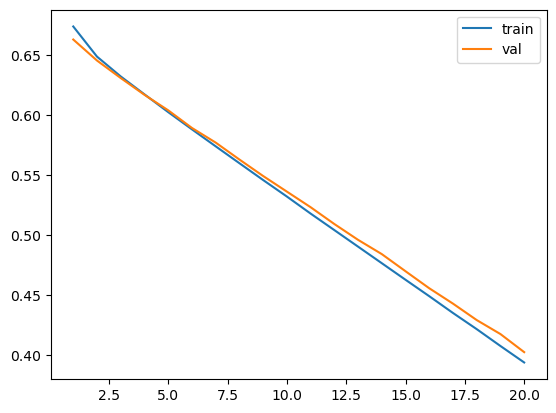

[PRE-TRAIN] Remaining time: 0.0 sec
==================== PRE-TRAIN finished! ====================


/var/folders/rz/fbmj4tjn7b323rcpx2bjkhxr0000gn/T/ipykernel_3435/3290006476.py:250: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  h = nn.Parameter(torch.FloatTensor(jth_x))


==================== GMM finished! ====================
Start plotting tSNE!


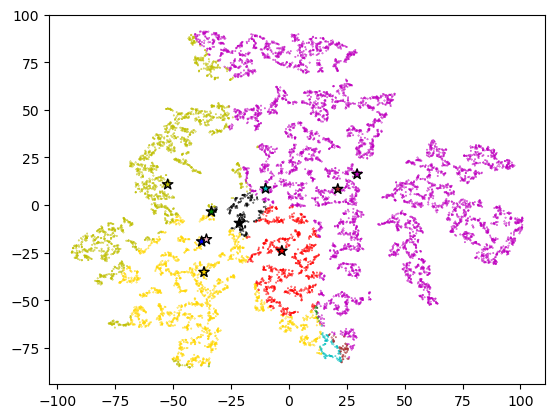

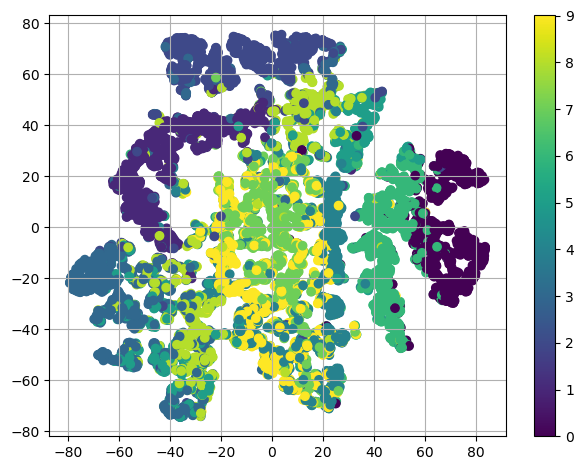

==================== GMM_tSNE finished! ====================
==================== start training ====================
Exp: 2_10 / Epoch: 1


/var/folders/rz/fbmj4tjn7b323rcpx2bjkhxr0000gn/T/ipykernel_3435/3290006476.py:149: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = nn.functional.softmax(self.pi)


Remaining time: 393.7950177192688 sec
Exp: 2_10 / Epoch: 2
Remaining time: 471.8210334777832 sec
Loss: 647.5651245117188
Exp: 2_10 / Epoch: 3
Remaining time: 370.4283936023712 sec
Loss: 647.6435546875
Exp: 2_10 / Epoch: 4
Remaining time: 324.18150758743286 sec
Loss: 647.5681762695312
Exp: 2_10 / Epoch: 5
Remaining time: 320.36229372024536 sec
Loss: 647.6155395507812
Exp: 2_10 / Epoch: 6
Remaining time: 311.58119773864746 sec
Loss: 647.6339111328125
Exp: 2_10 / Epoch: 7
Remaining time: 315.45462131500244 sec
Loss: 647.5491943359375
Exp: 2_10 / Epoch: 8
Remaining time: 303.57330322265625 sec
Loss: 647.6134643554688
Exp: 2_10 / Epoch: 9
Remaining time: 294.4386341571808 sec
Loss: 647.6259155273438
Exp: 2_10 / Epoch: 10
Remaining time: 285.9377193450928 sec
Loss: 647.6055908203125
Exp: 2_10 / Epoch: 11
Remaining time: 286.236722946167 sec
Loss: 647.656982421875
Exp: 2_10 / Epoch: 12
Remaining time: 283.9573678970337 sec
Loss: 647.61474609375
Exp: 2_10 / Epoch: 13
Remaining time: 273.928647

/var/folders/rz/fbmj4tjn7b323rcpx2bjkhxr0000gn/T/ipykernel_3435/2998360524.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = nn.functional.softmax(model_vade.pi)


start plotting!


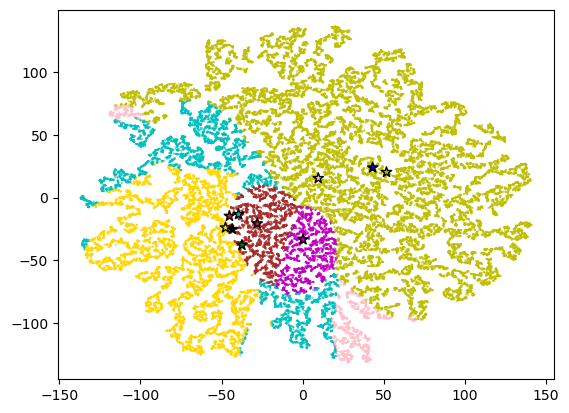

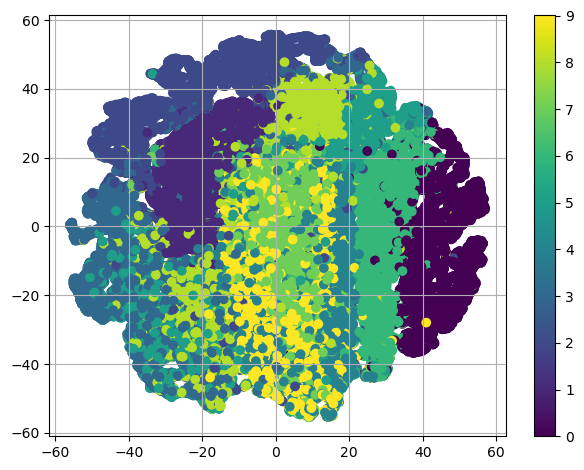

Remaining time: 0.0 sec
Loss: 647.6171875


In [8]:
model_vade.train(vade_epoch, vade_epoch_pre, x_train, y_train, x_val, x_test, y_test)

In [9]:
model_vade.test(x_test, y_test)
# test_tSNE(model_vade, x_train , True, 'tSNE_test.png')
# y_test = nn.functional.one_hot(y_test, 10)
# z_mu, z_lss = model_vade.model.encode(x_test)
# z = model_vade.model.reparameterize(z_mu, z_lss)  

/var/folders/rz/fbmj4tjn7b323rcpx2bjkhxr0000gn/T/ipykernel_3435/3290006476.py:361: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pi = nn.functional.softmax(self.pi)


MNIST dataset VaDE - clustering accuracy: 27.10%


(tensor([4, 6, 7,  ..., 4, 4, 4]), 0.271)